Import all required libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation
from pathlib import Path

Load Data and split it into training and testing data.

Below cell uploads using kaggle api. Alternatively, you can download the dataset
from https://www.kaggle.com/datasets/sonilnegi/spotted-cats-images and load it directly.

In [ ]:
! pip install kaggle

from google.colab import drive
drive.mount('/content/drive')

! mkdir ~/.kaggle
# Upload your Kaggle API token to your google drive as json file and then change the path in the below line before running.
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download sonilnegi/spotted-cats-images
! unzip spotted-cats-images.zip


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/sonilnegi/spotted-cats-images
License(s): CC0-1.0
spotted-cats-images.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  spotted-cats-images.zip
replace a/cheetahs/011c7ffc-8533-4166-aa30-b95f5b1c3884.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [90]:
path = Path('/content/cats_projekat/')
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(path,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,validation_split=0.2, subset='training', seed=42)
validation_dataset = image_dataset_from_directory(path, shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,validation_split=0.2,subset='validation',seed=42)

Found 2149 files belonging to 3 classes.
Using 1720 files for training.
Found 2149 files belonging to 3 classes.
Using 429 files for validation.


Checking distribution of images available for each image category.

In [91]:
cheetah_path = Path(path/'cheetahs')
jaguar_path = Path(path/'jaguars')
leopard_path = Path(path/'leopards')

# Count all files (not directories) in the folders
file_count = len([f for f in cheetah_path.iterdir() if f.is_file()])
print(f"Number of files in {cheetah_path.name}: {file_count}")
file_count = len([f for f in jaguar_path.iterdir() if f.is_file()])
print(f"Number of files in {jaguar_path.name}: {file_count}")
file_count = len([f for f in leopard_path.iterdir() if f.is_file()])
print(f"Number of files in {leopard_path.name}: {file_count}")

Number of files in cheetahs: 717
Number of files in jaguars: 704
Number of files in leopards: 728


A look at what the dataset looks like.


In [92]:
total = 0
for batch in train_dataset:
    total += batch[0].shape[0]
print(total)  # This will print 1540

1720


In [93]:
class_names = train_dataset.class_names
print(class_names)

['cheetahs', 'jaguars', 'leopards']


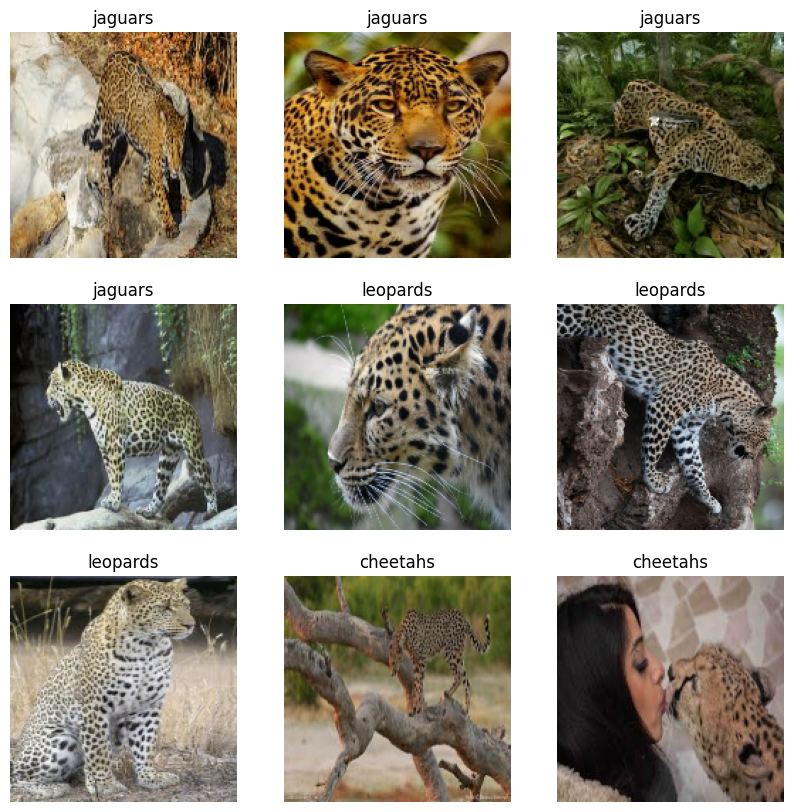

In [94]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Prefetching to improve efficiency by overlapping preprocessing and training on different batches.


In [95]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [96]:
# One hot encoding

NUM_CLASSES = 3  # cheetahs, jaguars, leopards

def one_hot_encode(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_dataset = train_dataset.map(one_hot_encode)
validation_dataset = validation_dataset.map(one_hot_encode)

Defining data augmentation, normalization, and prefetching Pipeline

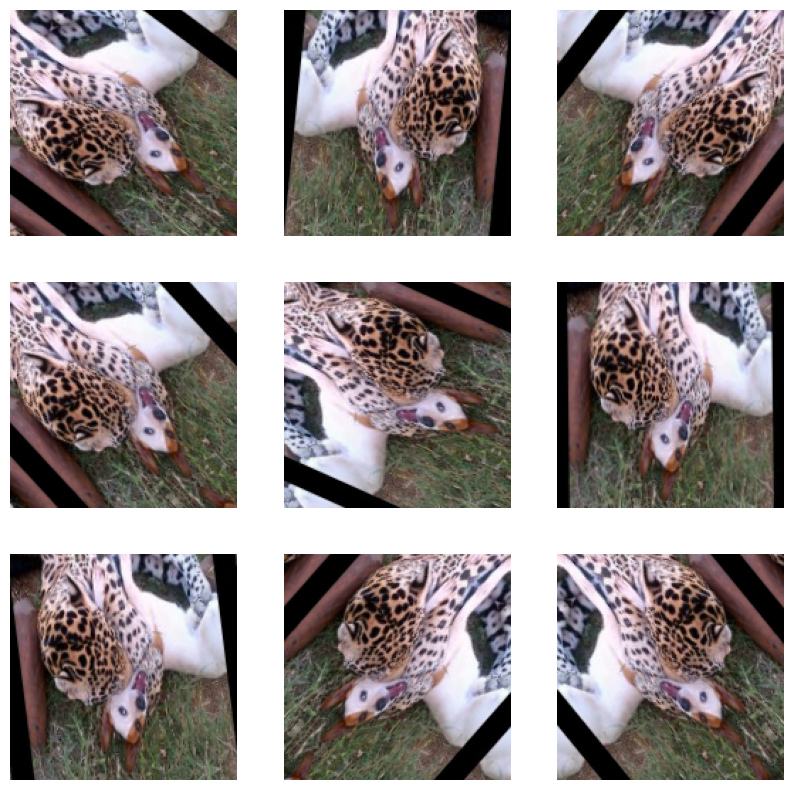

In [97]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [98]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation

Time to bring in Mobilenet.

In [99]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [100]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_path="imagenet_base_model/with_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160.h5"
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [101]:
base_model.summary()


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_16[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

Let us look at the last two layers.

In [102]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_6
predictions


Check Output shape

In [103]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


(32,1000) makes sense since 32 is batch size and Mobilenet originally has 1000 classes.

In [104]:
def bigcat_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):

    #to make sure the model expects RGB images as input.
    input_shape = image_shape + (3,)

    #load mobilenet_v2 as base feature extractor without including final classification layers.
    base_model_path="imagenet_base_model/without_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5"
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    x = data_augmentation(inputs)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # add the new classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)

    # use a prediction layer with threee neurons (three classes)
    outputs = tf.keras.layers.Dense(3)(x)

    model = tf.keras.Model(inputs, outputs)

    return model

In [105]:
model2 = bigcat_model(IMG_SIZE)


In [106]:
model2.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Configure the model before training. (which optimizer, loss function and metric to use.)

In [107]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Start training and track the progress.

In [108]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5279 - loss: 1.0345 - val_accuracy: 0.6900 - val_loss: 0.7188
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 947ms/step - accuracy: 0.7049 - loss: 0.6868 - val_accuracy: 0.6993 - val_loss: 0.6955
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7479 - loss: 0.6207 - val_accuracy: 0.6970 - val_loss: 0.6928
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 80s 967ms/step - accuracy: 0.7338 - loss: 0.6072 - val_accuracy: 0.7389 - val_loss: 0.6155
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 942ms/step - accuracy: 0.7565 - loss: 0.5633 - val_accuracy: 0.7366 - val_loss: 0.6281


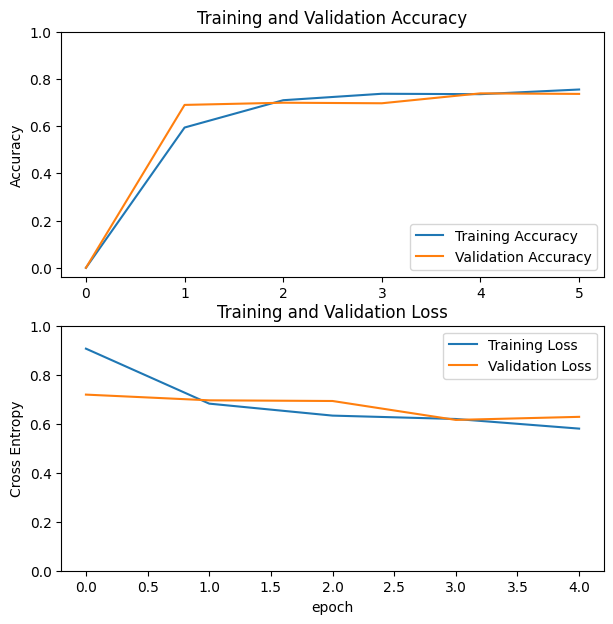

In [109]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(7,7))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Check on test data

In [110]:
path1 = Path('/content/a/')

IMG_SIZE = (160, 160)
test_dataset = image_dataset_from_directory(path1, shuffle=False, image_size=IMG_SIZE,  seed=42)
class_names2 = test_dataset.class_names
print(class_names2)

# One hot encoding of test data
NUM_CLASSES = 3  # cheetahs, jaguars, leopards

def one_hot_encode(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

test_dataset = test_dataset.map(one_hot_encode)
from pathlib import Path
from PIL import Image

test_dir = path1
for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            try:
                img = Image.open(img_path)
                img.verify()  # Verify that it is, in fact, an image
            except Exception as e:
                print(f"Removing corrupted file: {img_path}")
                img_path.unlink()  # Remove the file
import imghdr
from pathlib import Path

test_dir = path1

for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            img_type = imghdr.what(img_path)
            if img_type not in ['jpeg', 'png', 'bmp', 'gif']:
                print(f"Removing non-image or unsupported file: {img_path}")
                img_path.unlink()
results = model2.evaluate(test_dataset)
print("Test Accuracy :",results[1])

Found 483 files belonging to 3 classes.
['cheetahs', 'jaguars', 'leopards']
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 913ms/step - accuracy: 0.9006 - loss: 0.3042
Test Accuracy : 0.7888198494911194


**78.88% test accuracy**.


Let's see if we can improve this by fine tuning the top layers

In [111]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = None
# Define a loss function
loss_function= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  156


In [112]:

fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7534 - loss: 0.5396 - val_accuracy: 0.7459 - val_loss: 0.6014
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 971ms/step - accuracy: 0.7846 - loss: 0.5353 - val_accuracy: 0.7436 - val_loss: 0.6009
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 962ms/step - accuracy: 0.7781 - loss: 0.5124 - val_accuracy: 0.7483 - val_loss: 0.5966
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 973ms/step - accuracy: 0.7950 - loss: 0.4990 - val_accuracy: 0.7459 - val_loss: 0.5965
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 973ms/step - accuracy: 0.7728 - loss: 0.5232 - val_accuracy: 0.7529 - val_loss: 0.6024
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 932ms/step - accuracy: 0.7810 - loss: 0.5338 - val_accuracy: 0.7459 - val_loss: 0.5940


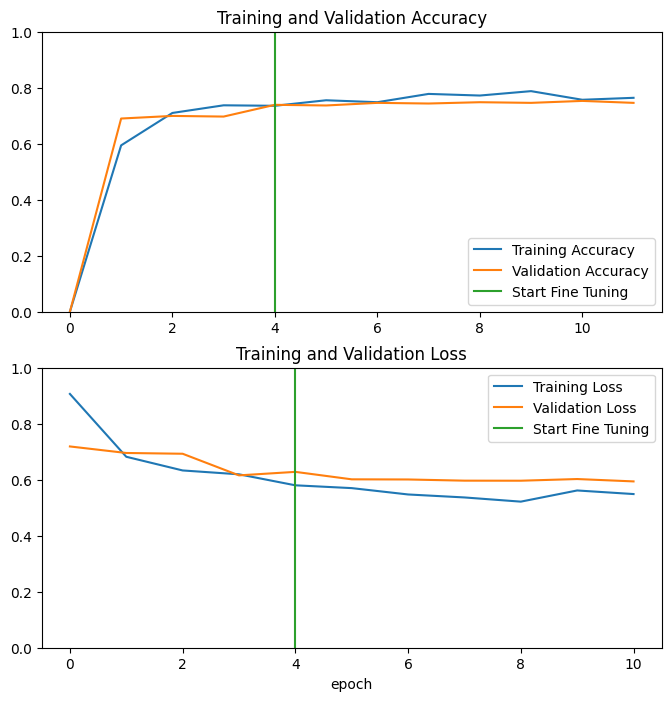

In [113]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [114]:
path1 = Path('/content/a/')

IMG_SIZE = (160, 160)
test_dataset = image_dataset_from_directory(path1, shuffle=False, image_size=IMG_SIZE,  seed=42)
class_names2 = test_dataset.class_names
print(class_names2)

# One hot encoding of test data
NUM_CLASSES = 3  # cheetahs, jaguars, leopards

def one_hot_encode(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

test_dataset = test_dataset.map(one_hot_encode)
from pathlib import Path
from PIL import Image

test_dir = path1
for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            try:
                img = Image.open(img_path)
                img.verify()  # Verify that it is, in fact, an image
            except Exception as e:
                print(f"Removing corrupted file: {img_path}")
                img_path.unlink()  # Remove the file
import imghdr
from pathlib import Path

test_dir = path1

for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            img_type = imghdr.what(img_path)
            if img_type not in ['jpeg', 'png', 'bmp', 'gif']:
                print(f"Removing non-image or unsupported file: {img_path}")
                img_path.unlink()
results = model2.evaluate(test_dataset)
print("Test Accuracy :",results[1])

Found 483 files belonging to 3 classes.
['cheetahs', 'jaguars', 'leopards']
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 925ms/step - accuracy: 0.9134 - loss: 0.2795
Test Accuracy : 0.8385093212127686


**83.85% Test Accuracy.**

5 percent improvement in accuracy through fine-tuning.